In [1]:
!pip install albumentations

In [2]:
import os
import numpy as np
from PIL import Image, ImageFilter
from functools import partial

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torchvision.transforms.functional as TF
from torchvision import models
from torch.nn import Module, Conv2d, Parameter, Softmax
from torchvision.transforms import v2

import matplotlib
import matplotlib.pyplot as plt

import datetime
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from models import MAResUNet, UNet, PretrainedResNet
from dataset import RoadSegmentationDataset, standardize
from metrics import compute_metrics, compute_f1_score
from training_functions import train_epoch, validate, get_predictions

In [3]:
#### Defines path for data ####

data_path="../data/training"
train_path= data_path + "/images"
label_path= data_path + "/groundtruth"

image_path_list=os.listdir(train_path)
image_path=os.path.join(train_path, image_path_list[0])
label_pt=os.path.join(label_path, image_path_list[0])

image = Image.open(image_path)
label = Image.open(label_pt)

image_array = np.array(image)
label_array = np.array(label)

#### Crashes on regular notebooks ####

# fig, ax= plt.subplots(1,2)
# ax[0].imshow(image_array)
# ax[1].imshow(label_array)

In [4]:
#### Data augmentation using albumentations library ####

trans=A.Compose(
        [A.Rotate(limit=70, p=1.0),
         A.VerticalFlip(p=0.1),
         A.HorizontalFlip(p=0.5),
         A.RandomSizedCrop(min_max_height=(200,200), height = 400, width = 400, p=0.1),
         A.RandomBrightnessContrast(p=0.2),
         ToTensorV2()
        ])

transform_x = standardize
trans_non_augmented = ToTensorV2()

In [5]:
#### Data loader ####

def get_dataloaders(batch_size, show_examples=False):

    dataset_augmented = RoadSegmentationDataset(data_dir=data_path, transform=trans, transform_x=transform_x)
    dataset_non_augmented = RoadSegmentationDataset(data_dir=data_path, transform=trans_non_augmented, transform_x=transform_x)
    dataset = ConcatDataset([dataset_augmented, dataset_non_augmented])
    #dataset = dataset_non_augmented
    val_percent=0.15
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,  # Shuffle the iteration order over the dataset
        pin_memory=torch.cuda.is_available(),
        drop_last=False,
        num_workers=2,
    )

    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
    )

    if show_examples:
      for batch in train_loader:
          images = batch[0]
          masks = batch[1]

          image = images[0]
          mask = masks[0]

          image_np = image.numpy()
          mask_np = mask.squeeze().numpy()

          plt.figure(figsize=(8, 4))

          plt.subplot(1, 2, 1)
          plt.imshow(np.transpose(image_np, (1, 2, 0)))
          plt.title('Image')
          plt.axis('off')

          plt.subplot(1, 2, 2)
          plt.imshow(mask_np, cmap='gray')
          plt.title('Mask')
          plt.axis('off')

          plt.show()

          # Break after the first batch
          break
    return train_loader, val_loader


#### set show_examples to True if you want samples ####

temp = get_dataloaders(
    batch_size=32,
    show_examples=False,
)
del temp

In [6]:
def compute_metrics(target, predicted_probs, threshold=0.5):
    predicted_binary = (predicted_probs > threshold).float()

    target_flat = target.view(-1)
    predicted_flat = predicted_binary.view(-1)

    correct_predictions = (target_flat == predicted_flat).float()
    accuracy = correct_predictions.mean().item()
    
    return np.round(accuracy,3)

def compute_f1_score(target_masks, predicted_masks, threshold=0.5):
    predicted_masks = (predicted_masks > threshold).float()

    target_flat = target_masks.view(-1)
    predicted_flat = predicted_masks.view(-1)

    tp = torch.sum(target_flat * predicted_flat)
    fp = torch.sum((1 - target_flat) * predicted_flat)
    fn = torch.sum(target_flat * (1 - predicted_flat))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    return f1_score.item()

In [7]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()
    #model.use_checkpointing()
    loss_history = []
    accuracy_history = []
    f1_score_history = []
    lr_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # pred = (output>0.5)
        # correct = (pred==target).sum().item()
        loss_float = loss.item()
        f1_float = compute_f1_score(target, output, 0.5)
        accuracy_float = compute_metrics(target, output, 0.5)

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        f1_score_history.append(f1_float)
        lr_history.append(scheduler.get_last_lr()[0])
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"batch_f1={f1_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )
            
    return loss_history, accuracy_history, lr_history , f1_score_history


@torch.no_grad()

def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)
        pred = (output>0.5)
        correct += compute_metrics(target, pred)
        f1 = compute_f1_score(target, pred)

    test_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(val_loader.dataset),
            100.0 * correct / len(val_loader.dataset),
        )
    )
    return test_loss, correct , f1

In [8]:
#### training function ####

def run_training(model_factory, num_epochs, data_kwargs, optimizer_kwargs, device="cuda"):
    
    # Data Loading 
    train_loader, val_loader = get_dataloaders(**data_kwargs)
    model = model_factory
    model = model.to(device=device)
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    criterion = torch.nn.functional.binary_cross_entropy
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max = (len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    lr_history = []
    train_loss_history = []
    train_acc_history = []
    train_f1_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []

    for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs"):
        train_loss, train_acc, lrs, f1_score = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        train_f1_history.extend(f1_score)
        lr_history.extend(lrs)

        val_loss, val_acc, f1_val = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        val_f1_history.append(f1_val)

    # Plot training curves
    n_train = len(train_loss_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(6.4 * 3, 4.8))
    plt.subplot(1, 3, 1)
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 1)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")

    # Plot low/high loss predictions on validation set
    points = get_predictions(
        model,
        device,
        val_loader,
        partial(torch.nn.functional.cross_entropy, reduction="none"),
    )

    for i, (data, loss, pred, target) in enumerate(points[:5]):
        plt.figure(figsize=(12, 4))
        print(np.squeeze(data, axis=0).shape)
        print(pred.shape)
        print(target.shape)

        mask_pred=(pred>0.5)

        # Plotting the input image
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(np.squeeze(data, axis=0), (1,2,0)), cmap='gray')
        plt.title('Input Image')

        # Plotting the predicted labels
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(np.squeeze(mask_pred, axis=0), (1,2,0)), cmap='viridis', vmin=0, vmax=1)  # Assuming binary classification
        plt.title('Predicted Label')

        # Plotting the ground truth labels
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(np.squeeze(target, axis=0), (1,2,0)), cmap='viridis', vmin=0, vmax=1)  # Assuming binary classification
        plt.title('Ground Truth Label')

        plt.show()


    return val_acc

C:\Users\malou\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\malou\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\malou/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.8MB/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


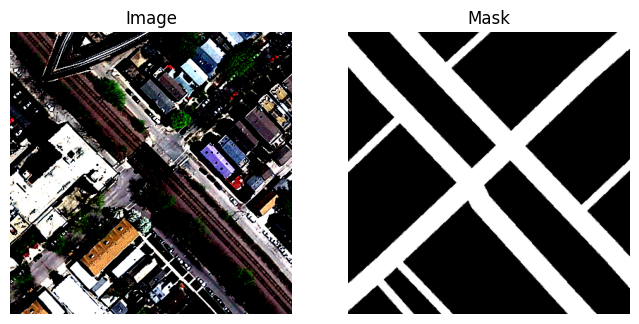

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
#### Training loop ####

optimizer_kwargs = dict(
    lr=5e-4,
    weight_decay=1e-3,
)

num_epochs = 300 # best 300
n_channels = 3
n_classes = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_1 = UNet(n_channels,n_classes).to(device)
# model_2 = MAResUNet(n_channels,n_classes).to("cpu")
# model_3 = PretrainedResNet(n_channels, n_classes,pretrained_backbone=True).to(device)

# model_factory = model_1 # -----> UNet
# model_factory = model_2 # -----> MAResUNet
# model_factory = model_3 # -----> UNet Pretrained

data_kwargs = dict(
    batch_size=16,
    show_examples=True)

run_training(
    model_factory = model_factory,
    num_epochs = num_epochs,
    optimizer_kwargs = optimizer_kwargs,
    data_kwargs = data_kwargs,
    device = device)